In [29]:

import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
from utils import *
from modules import UNet_conditional, EMA, UNet_conditional_concat, UNet_conditional_fully_concat, UNet_conditional_fully_add
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
"""
需要修改的地方：

"""

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=240, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def _timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=0):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        return x

def inpaint_image(original_image, generated_image, mask):
    """
    将生成的图像融合到原始图像的指定区域中。
    
    参数:
    original_image (torch.Tensor): 原始图像
    generated_image (torch.Tensor): 生成的图像
    mask (torch.Tensor): 掩码图像, 1表示需要inpaint的区域, 0表示保留原图
    
    返回:
    torch.Tensor: 输出的合成图像
    """
    # 将三个输入tensor转换到相同的设备上
    device = original_image.device
    mask = mask.to(device)
    generated_image = generated_image.to(device)
    
    # 使用掩码融合原图和生成的图像
    output_image = original_image.clone()
    # print(output_image.shape, mask.shape, generated_image.shape)
    output_image = output_image * (1 - mask) + generated_image * mask
    
    return output_image



import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()
args.run_name = "DDPM_conditional"
args.batch_size = 5
args.image_size = 96#这个参数有什么用，和原始图像的关系是什么
# args.dataset_path =  r"D:\ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training"
args.dataset_path =  r"C:\Users\DELL\Desktop\DDPM\ddpm_brats\DDPM_brain\test_data"
args.device = "cuda"
args.lr = 3e-4
args.train = True
args.shuffle = False
device = 'cuda'
dataloader = get_data(args)
model = UNet_conditional_concat().to(device)
ckpt = torch.load("./models/DDPM_conditional/ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=args.image_size, device=device)
pbar = tqdm(dataloader)
images, cropped_images, masks = next(iter(pbar))
modefied_images = cropped_images
b, _, _, _ = images.shape
d_images = diffusion.sample(model, n=b, labels=modefied_images)




  0%|          | 0/2 [00:00<?, ?it/s]
11:18:23 - INFO: Sampling 5 new images....
999it [00:41, 24.28it/s]


In [30]:
def inpaint_image(original_image, generated_image, mask):
    """
    将生成的图像融合到原始图像的指定区域中。
    
    参数:
    original_image (torch.Tensor): 原始图像
    generated_image (torch.Tensor): 生成的图像
    mask (torch.Tensor): 掩码图像, 1表示需要inpaint的区域, 0表示保留原图
    
    返回:
    torch.Tensor: 输出的合成图像
    """
    # 将三个输入tensor转换到相同的设备上
    device = original_image.device
    mask = mask.to(device)
    generated_image = generated_image.to(device)
    
    # 使用掩码融合原图和生成的图像
    output_image = original_image.clone()
    print(output_image.shape, mask.shape, generated_image.shape)
    # print(output_image.shape, mask.shape, generated_image.shape)
    reference_image = output_image * mask
    output_image = output_image * (1 - mask) + generated_image * mask
    generated_image = generated_image * mask
    
    return output_image, generated_image, reference_image
images_predict_slice, generated_image, reference_image = inpaint_image(images[:,:,:,:], d_images[:,:,:,:], masks[:,:,:,:])


torch.Size([5, 1, 96, 96]) torch.Size([5, 1, 96, 96]) torch.Size([5, 1, 96, 96])


g_img 中包含非0元素


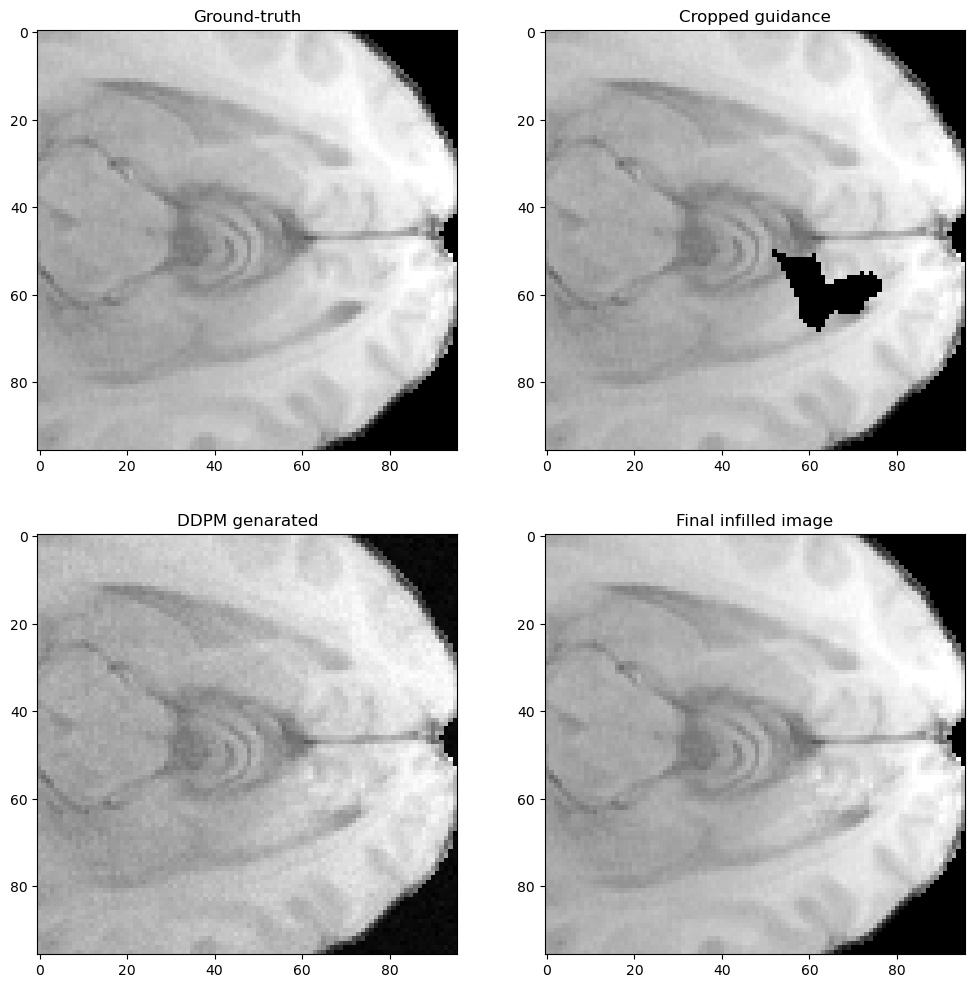

<Figure size 800x800 with 0 Axes>

In [34]:
import torch
import matplotlib.pyplot as plt



# 选择要显示的图像索引
index = 3
images = images.cpu()
d_images_new = images_predict_slice.cpu()
dd = d_images[:,:,:,:].cpu()
cropped_images = modefied_images.cpu()
g_images = generated_image.cpu()
r_images = reference_image.cpu()
masks_clone = masks.clone().cpu()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# 获取选中的图像
img = images[index, 0, :, :]
d_img = d_images_new[index, 0, :, :]
c_img = cropped_images[index, 0, :, :]
g_img = g_images[index, 0, :, :]
r_img = r_images[index, 0, :, :]
dd_img = dd[index, 0, :, :]
# print(g_img)
# print(img[10,:])
if torch.any(g_img != 0):
    print("g_img 中包含非0元素")
else:
    print("g_img 中全是0")
non_zero_elements = g_img[g_img != 0]
# print(non_zero_elements)
# 使用 matplotlib 显示图像
plt.figure(figsize=(8, 8))
axes[0,0].imshow(img, cmap='gray')
axes[0,0].set_title('Ground-truth')
axes[0,1].imshow(c_img, cmap='gray')
axes[0,1].set_title('Cropped guidance')
axes[1,0].imshow(dd_img, cmap='gray')
axes[1,0].set_title('DDPM genarated')
axes[1,1].imshow(d_img, cmap='gray')
axes[1,1].set_title('Final infilled image')
plt.show()
mse = nn.MSELoss()
# loss = mse(reference_image, masks_clone)
# print(loss)

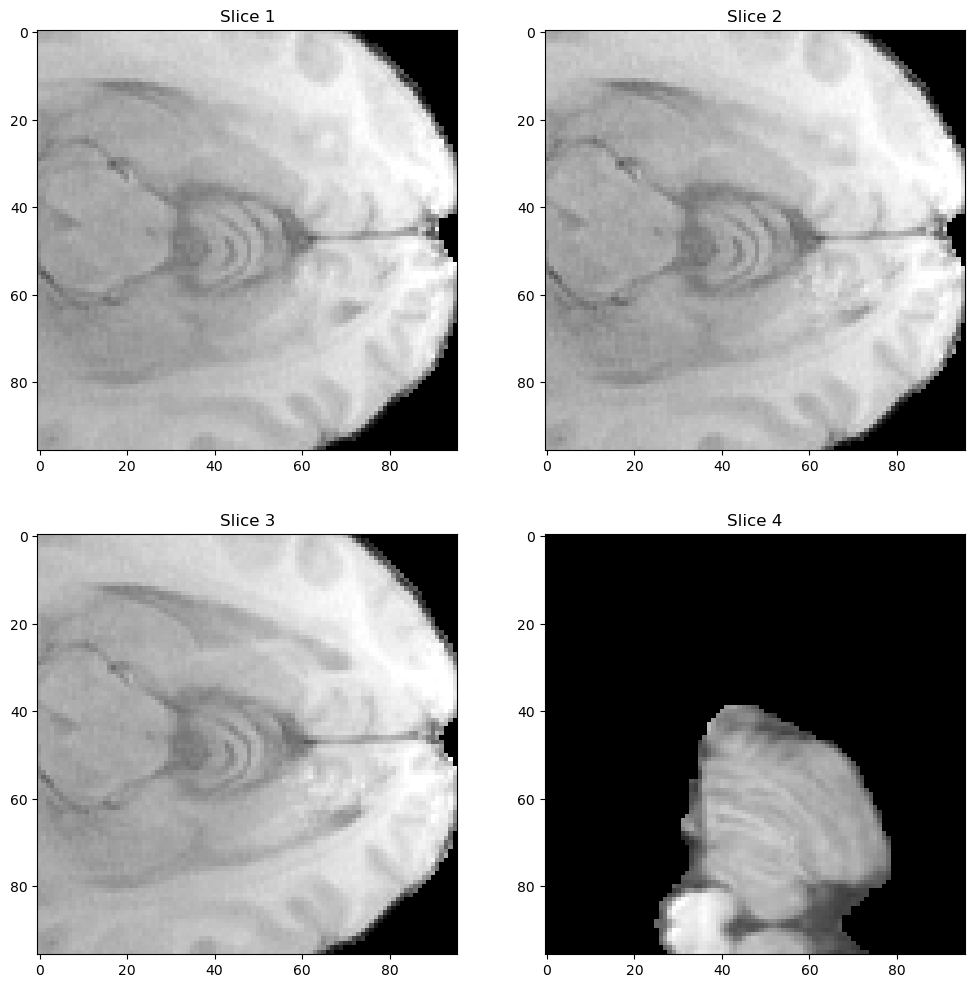

<Figure size 800x800 with 0 Axes>

In [32]:
d_1 = d_images_new[1, 0, :, :]
d_2 = d_images_new[2, 0, :, :]
d_3 = d_images_new[3, 0, :, :]
d_4 = d_images_new[4, 0, :, :]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.figure(figsize=(8, 8))
axes[0,0].imshow(d_1, cmap='gray')
axes[0,0].set_title('Slice 1')
axes[0,1].imshow(d_2, cmap='gray')
axes[0,1].set_title('Slice 2')
axes[1,0].imshow(d_3, cmap='gray')
axes[1,0].set_title('Slice 3')
axes[1,1].imshow(d_4, cmap='gray')
axes[1,1].set_title('Slice 4')
plt.show()

In [ ]:
from inpainting.challenge_metrics_2023 import generate_metrics
performance = {}
initialized = False

result_path = '-result.nii.gz'
result_img = nib.load(result_path)
result = torch.Tensor(result_img.get_fdata()).unsqueeze(0)

# Healthy mask (evaluation volume)
mask_path = f"-mask-healthy.nii.gz"
mask_img = nib.load(mask_path)
mask_healthy = torch.Tensor(mask_img.get_fdata()).bool().unsqueeze(0)

# Reference (ground truth)
t1n_path = f"-t1n.nii.gz"
t1n_img = nib.load(t1n_path)
t1n = torch.Tensor(t1n_img.get_fdata()).unsqueeze(0)

# Normalization Tensor (on what basis shall be normalized? On the model input!)
t1n_voided_path = f"-t1n-voided.nii.gz"
t1n_voided_img = nib.load(t1n_voided_path)
t1n_voided = torch.Tensor(t1n_voided_img.get_fdata()).unsqueeze(0)

# Compute metrics
metrics_dict = generate_metrics( #expected Tensor dimension: 1 x 255 x 255 x 
    prediction=result,
    target=t1n,
    mask=mask_healthy,
    normalization_tensor= t1n_voided #former: t1n * ~mask_healthy
    )
    
# Initialize if necessary
# if(initialized == False):
#     print(f"FolderName\t",end="")
#     performance["folderName"] = []
#     for metric_name in metrics_dict.keys():
#         print(f"\t\t{metric_name}",end="")
#         performance[metric_name] = []
#     print()
#     initialized = True

#Add data to performance dict and print it
# performance["folderName"].append(folderName)
# print(f'{folderName}\t',end="")
# for metric_name in metrics_dict.keys():
#     performance[metric_name].append(metrics_dict[metric_name])
#     print(f"\t{metrics_dict[metric_name]:.8f}",end="")
# print("\n")